###  Fitting the equilibrium model to PAR-2 rundown data

Context:
- Fitting the model to PAR-2(wt) and PAR-2(L109R) rundown data using a shared membrane affinity parameter
- Testing a few different fitting approaches:
    - Constraing wt dimerisation to the value experimentally determined by AUC vs free fitting
    - A few different values for the cortical thickness parameter, which controls the degree of absolute concentration enrichment upon membrane association

Results:
- Generally shows very good concordance, compatible with dimerisation at the membrane (reduced for the mutant) and monomers in the cytoplasm
- Free fitting wild type dimer strength independently reproduces a value very similar to the AUC value
- Fits look best when cortical thickness = 5 (which is the expected value based on the expected diameter of PAR-2)

Dependencies:
- Relies on quantification data processed by _00_ProcessData.ipynb_

In [1]:
import sys, os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
sys.path.append('../../..')
from src import random_grouped_scatter, lighten, minor_ticks, log_molar_to_micromolar, EnergiesConfidenceIntervalPaired
from matplotlib.legend_handler import HandlerTuple
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 150

if not os.path.exists('Figs'):
    os.mkdir('Figs')

### Import data

In [2]:
df_main = pd.read_csv("df_main.csv")
df_s1 = pd.read_csv("df_s1.csv")
df_s2 = pd.read_csv("df_s2.csv")

### Run analysis

In [3]:
# Association constants expressed in log10 form
Ka_wt = 6.446  # <- AUC measurement
Ka_mut = 6.446  # <- initial guess
Km = 2.5  # <- initial guass
fix_wt = True
fix_mut = False
fit_D = False

analysis_main = EnergiesConfidenceIntervalPaired(
    df_main,
    log=True,
    p0=(Ka_wt, Ka_mut, Km),
    fix_wt=fix_wt,
    fix_mut=fix_mut,
    fit_D=fit_D,
)
analysis_s1 = EnergiesConfidenceIntervalPaired(
    df_s1, log=True, p0=(Ka_wt, Ka_mut, Km), fix_wt=fix_wt, fix_mut=fix_mut, fit_D=fit_D
)
analysis_s2 = EnergiesConfidenceIntervalPaired(
    df_s2, log=True, p0=(Ka_wt, Ka_mut, Km), fix_wt=fix_wt, fix_mut=fix_mut, fit_D=fit_D
)

analysis_main_free = EnergiesConfidenceIntervalPaired(
    df_main,
    log=True,
    p0=(Ka_wt, Ka_mut, Km),
    fix_wt=False,
    fix_mut=fix_mut,
    fit_D=fit_D,
)
analysis_s1_free = EnergiesConfidenceIntervalPaired(
    df_s1, log=True, p0=(Ka_wt, Ka_mut, Km), fix_wt=False, fix_mut=fix_mut, fit_D=fit_D
)
analysis_s2_free = EnergiesConfidenceIntervalPaired(
    df_s2, log=True, p0=(Ka_wt, Ka_mut, Km), fix_wt=False, fix_mut=fix_mut, fit_D=fit_D
)

/Users/blandt/anaconda3/anaconda3/envs/par2_paper/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


### Plotting functions

In [4]:
def rundown_plot(analysis, v1=True, path=None):
    # Initiate figure
    fig = plt.figure(figsize=(4, 4))
    gs = fig.add_gridspec(
        2,
        2,
        width_ratios=(9, 2),
        height_ratios=(2, 9),
        left=0.2,
        right=0.8,
        bottom=0.2,
        top=0.8,
        wspace=0.1,
        hspace=0.1,
    )
    ax = fig.add_subplot(gs[1, 0])
    ax_dimx = fig.add_subplot(gs[0, 0])
    ax_dimy = fig.add_subplot(gs[1, 1])

    # Scatter
    b = np.array([r == "Pol" for r in analysis.unipol])
    r = random_grouped_scatter()
    r.add(
        analysis.cyts[(analysis.l109r == 0) * ~b],
        analysis.mems[(analysis.l109r == 0) * ~b],
        lighten("tab:blue"),
    )
    r.add(
        analysis.cyts[(analysis.l109r == 0) * b],
        analysis.mems[(analysis.l109r == 0) * b],
        "tab:blue",
    )
    r.add(
        analysis.cyts[(analysis.l109r == 1) * ~b],
        analysis.mems[(analysis.l109r == 1) * ~b],
        lighten("tab:orange"),
    )
    r.add(
        analysis.cyts[(analysis.l109r == 1) * b],
        analysis.mems[(analysis.l109r == 1) * b],
        color="tab:orange",
    )
    r.plot(ax)

    # Plot model
    ax.plot(analysis.res_x[0], analysis.res_y[0], c="k", linewidth=1)
    ax.plot(analysis.res_x[1], analysis.res_y[1], c="k", linewidth=1)
    ax.tick_params(axis="both", labelsize=8)

    # Add lines and ticks
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    for i in np.arange(-10, 10, 0.5):
        ax.plot([-10, 10], [i - 10, i + 10], c="0.9", zorder=-100, linewidth=1)
    ax.set_xticks(np.arange(-10, 0))
    ax.set_yticks(np.arange(-10, 0))
    minor_ticks(ax, [-10, 0], [-10, 0])
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.xaxis.set_major_formatter(log_molar_to_micromolar)
    ax.yaxis.set_major_formatter(log_molar_to_micromolar)
    ax.set_xlabel("Cytoplasmic concentration (µM)", fontsize=8)
    ax.set_ylabel("Membrane concentration (µM)", fontsize=8)

    # Set axis limits
    ax.set_ylim(min(analysis.mems) - 0.1, max(analysis.mems) + 0.2)
    ax.set_xlim(min(analysis.cyts) - 0.1, max(analysis.cyts) + 0.15)
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # Legend
    s = 25
    top_left = ax.scatter([], [], linewidth=0.1, edgecolors="k", color="tab:blue", s=s)
    bottom_left = ax.scatter(
        [], [], linewidth=0.1, edgecolors="k", color="tab:orange", s=s
    )
    top_right = ax.scatter(
        [], [], linewidth=0.1, edgecolors="k", color=lighten("tab:blue", 1.7), s=s
    )
    bottom_right = ax.scatter(
        [], [], linewidth=0.1, edgecolors="k", color=lighten("tab:orange", 1.7), s=s
    )
    ax.legend(
        [(top_left, top_right), (bottom_left, bottom_right)],
        ["PAR-2(WT)", "PAR-2(L109R)"],
        fontsize=8,
        handler_map={tuple: HandlerTuple(ndivide=None, pad=1)},
        loc=(0.04, 0.8),
        frameon=False,
    )
    ax.text(
        x=0.055,
        y=0.79,
        s="par-3(wt)",
        ha="left",
        va="top",
        rotation=90,
        transform=ax.transAxes,
        fontsize=8,
        fontstyle="italic",
    )
    ax.text(
        x=0.14,
        y=0.79,
        s="par-3(it71)",
        ha="left",
        va="top",
        rotation=90,
        transform=ax.transAxes,
        fontsize=8,
        fontstyle="italic",
    )

    # Cytoplasmic dimer fraction
    ax_dimx.plot(analysis.res_x[0], analysis.cyt_dim[0], c="tab:blue")
    ax_dimx.plot(analysis.res_x[1], analysis.cyt_dim[1], c="tab:orange")
    ax_dimx.set_ylim(-5, 105)
    ax_dimx.set_xlim(*xlim)
    ax_dimx.set_xticks([])
    ax_dimx.set_ylabel("% Dimer\n(cyt)", fontsize=8)
    ax_dimx.tick_params(axis="both", labelsize=8)

    # Membrane dimer fraction
    ax_dimy.plot(analysis.mem_dim[0], analysis.res_y[0], c="tab:blue")
    ax_dimy.plot(analysis.mem_dim[1], analysis.res_y[1], c="tab:orange")
    ax_dimy.set_xlim(-5, 105)
    ax_dimy.set_ylim(*ylim)
    ax_dimy.set_yticks([])
    ax_dimy.set_xlabel("% Dimer\n(mem)", fontsize=8)
    ax_dimy.tick_params(axis="both", labelsize=8)

    # Text box
    if v1:
        if analysis.fix_wt:
            s1 = (
                r"$K\mathrm{_D^{dim}}$"
                + "(WT) = %.2f" % (10 ** (-analysis.ka_full[0] + 6))
                + "µM (AUC)"
            )
        else:
            s1 = (
                r"$K\mathrm{_D^{dim}}$"
                + "(WT) = %.2f" % (10 ** (-analysis.ka_full[0] + 6))
                + "µM (fit)"
            )
        s2 = (
            r"$K\mathrm{_D^{dim}}$"
            + "(L109R) = %.2f" % (10 ** (-analysis.ka_full[1] + 6))
            + "µM (fit)"
        )
        print(analysis.km_full)
        s3 = (
            r"$K\mathrm{_D^{mem}}$"
            + " = "
            + r"$10^{%.2f}$" % (-analysis.km_full)
            + " (fit)"
        )
        s = s1 + "\n" + s2 + "\n" + s3
        ax.text(
            x=0.27,
            y=0.05,
            s=s,
            transform=ax.transAxes,
            horizontalalignment="left",
            verticalalignment="bottom",
            fontsize=7,
            bbox=dict(facecolor="w", edgecolor="k", linewidth=0.5, alpha=0.8),
        )

    else:
        s1 = (
            r"$K\mathrm{_D^{dim}}$"
            + "(WT) = %.2f" % (10 ** (-analysis.ka_full[0] + 6))
            + "µM"
        )
        s2 = (
            r"$K\mathrm{_D^{dim}}$"
            + "(L109R) = %.2f" % (10 ** (-analysis.ka_full[1] + 6))
            + "µM"
        )
        print(analysis.km_full)
        s3 = r"$K\mathrm{_D^{mem}}$" + " = " + r"$10^{%.2f}$" % (-analysis.km_full)
        s = r"$\bf {Fit\:parameters:}$" + "\n" + s1 + "\n" + s2 + "\n" + s3
        ax.text(
            x=0.37,
            y=0.05,
            s=s,
            transform=ax.transAxes,
            horizontalalignment="left",
            verticalalignment="bottom",
            fontsize=7,
            bbox=dict(facecolor="w", edgecolor="k", linewidth=0.5, alpha=0.8),
        )

    # Save figure
    fig.savefig(path, dpi=600, transparent=True)

### Plots

2.394639964062579


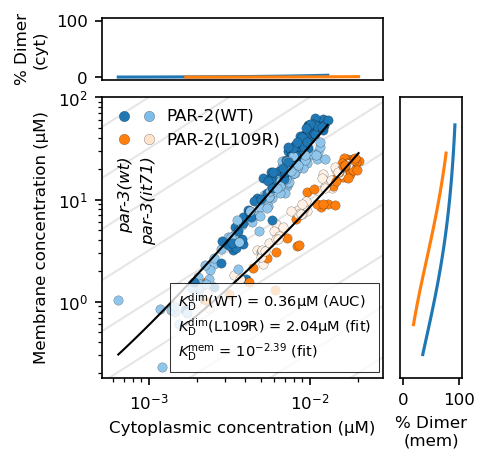

In [5]:
rundown_plot(analysis_main, path="Figs/model_fit_main.png")

2.914444408736237


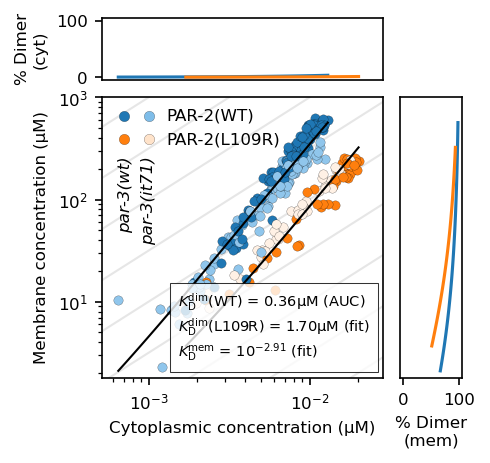

In [6]:
rundown_plot(analysis_s1, path="Figs/model_fit_s1.png")

1.8321420982863337


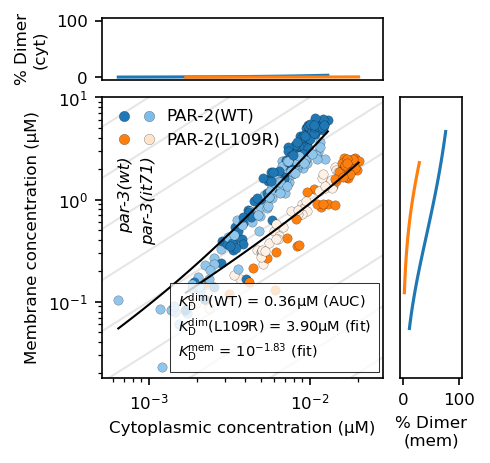

In [7]:
rundown_plot(analysis_s2, path="Figs/model_fit_s2.png")

2.42694797189416


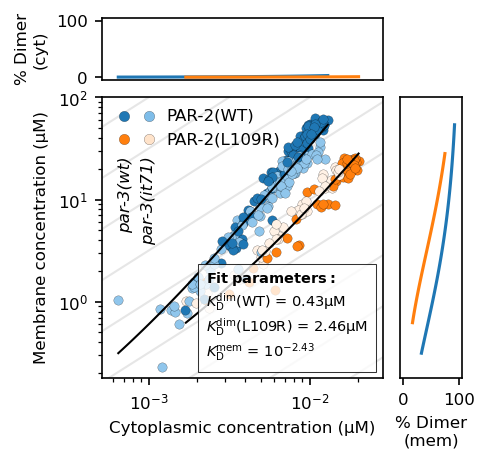

In [8]:
rundown_plot(analysis_main_free, v1=False, path="Figs/model_fit_main_free.png")

3.3805768094003725


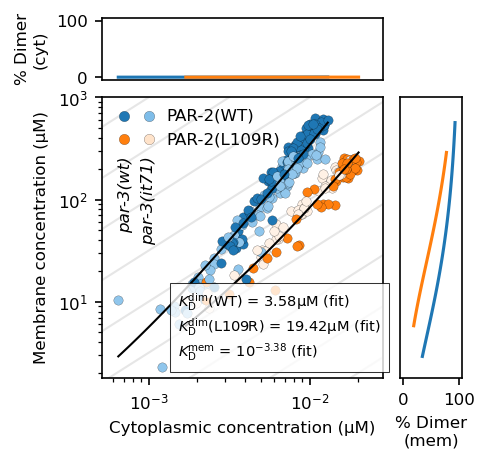

In [9]:
rundown_plot(analysis_s1_free, path="Figs/model_fit_s1_free.png")

1.623809480840481


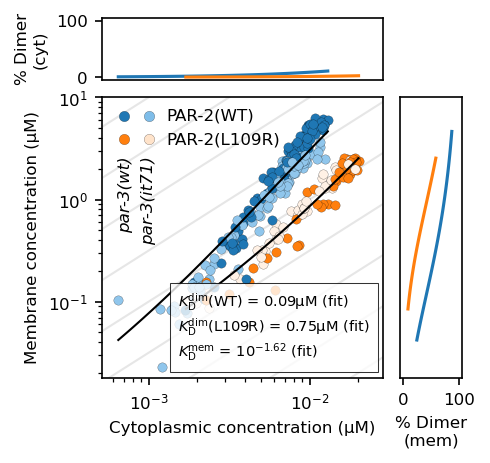

In [10]:
rundown_plot(analysis_s2_free, path="Figs/model_fit_s2_free.png")